In [1]:
import re
import pandas as pd
import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import *
import matplotlib.pyplot as plt
from cleantext import clean
from io import StringIO
import numpy as np

import pickle 

### Hent data

In [2]:

# URL of the CSV file
url = 'https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv'

# Fetching the content from the URL
response = requests.get(url)

# Checking if the request was successful (status code 200)
if response.status_code == 200:
    # Reading CSV data using pandas
    csv_data = StringIO(response.text)
    df = pd.read_csv(csv_data)

    # Displaying the first few rows of the DataFrame
    #print(df.head())
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")


# Part 1

# Task 1

In [3]:
def clean_text(text):
    text = text.lower()
    # remove multiple white spaces/tabs or newlines
    mul_uni_whitespaces = re.compile(r'(\s)\s+')
    text = mul_uni_whitespaces.sub(r'\1',text)
    # extract dates with form
    # YY-MM-DD HH-MM:SS
    date = re.compile(r"""
        # YY
        ([0-1][0-9]{3}|20[0-1][0-9]|202[0-4])
        -
        # MM 01-12, DD: 01-31
        (1[0-2]|0[1-9])
        -
        ([1-3]0|[0-2][1-9]|31)
        # whitespace
        \ {1}
        # HH-MM:SS format
        ([0-1][0-9]|2[0-4]):([0-5][0-9]|60):([0-5][0-9].\d*)
        """, re.X)
    text = date.sub(r'<DATE>',text)
    # extract date with alphabetic name, year
    # example: Jan DD, YYYY
    date_2 = re.compile(r"""
        ([A-Z]|[a-z])([a-z]+\ )([1-3]0|[0-2][1-9]|31)
        ,\ {1}
        # YY 0000-2023
        ([0-1][0-9]{3}|20[0-1][0-9]|202[0-4])
        """, re.X)
    text = date_2.sub(r'<DATE>',text)
    
    number = re.compile(r"""
        (\d+[,\.]\d+)|(\d+)  
        (?![\w])             # next character has to be a non-word letter
        """, re.X)
    text = number.sub(r'<NUM>',text)
    
    email = re.compile(r"""
        [\w-]+@[\.\w-]+              # if we have @ we assume it's an email 
        """, re.X)
    text = email.sub(r'<EMAIL>',text)
    
    # website with prefix http and/or www.
    website_http = re.compile(r"""
        (https?://www\.|              # http(s)://www. or www.
        https?://|www\.)              # or http(s)://
        ([^ \t\n\r\f\v,]+)             # capture rest of website    
        """, re.X)
    text = website_http.sub(r'<URL>',text)
    # website with prefix http and/or www.
    website = re.compile(r"""        # no https or www
        [\w-]+\.[\.\w-]+             # assume website if we have a dot .
        (/[^ \t\n\r\f\v,]*)?         # /<address> optional     
        """, re.X)
    text = website.sub(r'<URL>',text)
    return text


In [12]:
concat_content = " ".join(df['content'].tolist())
cleaned_content = clean_text(concat_content)
tokens = nltk.word_tokenize(cleaned_content)
tokens = [token for token in tokens if token.isalpha()]

# stop word removal
vocab_pre_stop = len(np.unique(tokens))
stop_words = stopwords.words('english')
tokens_no_stop = [token for token in tokens if not token in stop_words]
vocab_post_stop = len(np.unique(tokens_no_stop))

# stemming
stemmer = PorterStemmer()
tokens_stem = [stemmer.stem(token) for token in tokens_no_stop]
vocab_post_stem = len(np.unique(tokens_stem))

print(f"Vocabulary size before removing stop words: {vocab_pre_stop}")
print(f"Vocabulary size before after stop words: {vocab_post_stop}")
print(f"Reduction rate is: {(vocab_pre_stop-vocab_post_stop)/vocab_pre_stop}")
print(f"\nVocabulary size after stemming: {vocab_post_stem}")
print(f"Reduction rate after stemming: {(vocab_post_stop-vocab_post_stem)/vocab_post_stop}")

Vocabulary size before removing stop words: 14961
Vocabulary size before after stop words: 14815
Reduction rate is: 0.00975870596885235

Vocabulary size after stemming: 9674
Reduction rate after stemming: 0.3470131623354708


# Task 2

In [27]:
# compute vocab frequency before stop words / stemming
'''
chunksize = 50000

word_dict = {}

counter =0
for chunk in pd.read_csv('995,000_rows.csv', chunksize=chunksize):
##import matplotlib.pyplot as plt
    counter += 1
    print(counter)
    chunk = chunk.dropna(subset = ['type'])
    chunk = chunk.dropna(subset = ['content'])
    for i in range(len(chunk['content'])):
        content = chunk['content'].iloc[i]
        clean_data = clean_text(content)
        tokens = nltk.word_tokenize(clean_data)
        tokens = [token for token in tokens if token.isalpha()]
        for k in range(len(tokens)):
            word = tokens[k]
            if word not in word_dict:
                word_dict[word] = 1
            else:
                count = word_dict[word]
                word_dict.update({word:count+1})
'''
#with open('word_dictionary.pkl', 'wb') as f:
#    pickle.dump(word_dict, f)
with open('word_dictionary_pre.pkl', 'rb') as f:
    word_dict = pickle.load(f)

In [14]:
# vocab freq after stop word / stemming
'''
chunksize = 100000
import matplotlib.pyplot as plt

word_dict_post = {}
counter = 0
for chunk in pd.read_csv('995,000_rows.csv', chunksize=chunksize):
##import matplotlib.pyplot as plt
    counter += 1
    print(counter)
    chunk = chunk.dropna(subset = ['type'])
    chunk = chunk.dropna(subset = ['content'])
    for i in range(len(chunk['content'])):
        content = chunk['content'].iloc[i]
        clean_data = clean_text(content)
        tokens = nltk.word_tokenize(clean_data)
        tokens = [token for token in tokens if token.isalpha()]

        stop_words = stopwords.words('english')
        tokens_no_stop = [token for token in tokens if not token in stop_words]

        # stemming
        stemmer = PorterStemmer()
        tokens_stem = [stemmer.stem(token) for token in tokens_no_stop]

        for k in range(len(tokens_stem)):
            word = tokens_stem[k]
            if word not in word_dict_post:
                word_dict_post[word] = 1
            else:
                count = word_dict_post[word]
                word_dict_post.update({word:count+1})
'''

#with open('word_dictionary_post.pkl', 'wb') as f:
#    pickle.dump(word_dict_post, f)
with open('word_dictionary_post.pkl', 'rb') as f:
    word_dict_post = pickle.load(f)

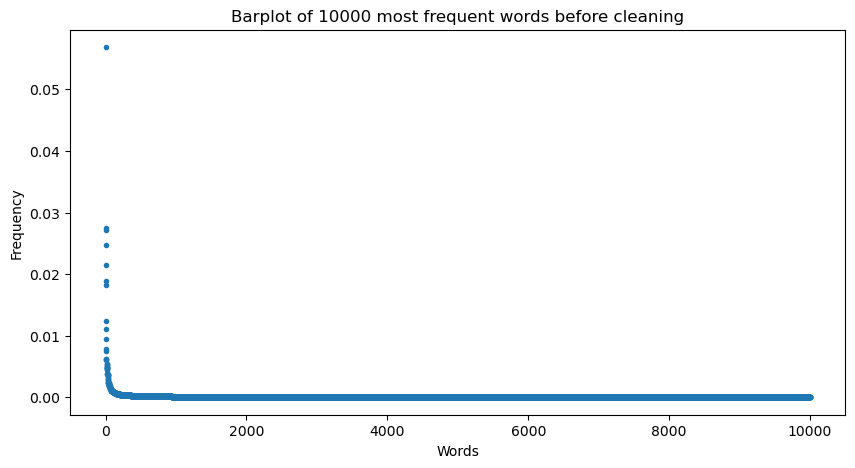

In [65]:
# Analysis of word frequency
freq_100 = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[0:100]
freq_10000 = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[0:10000]
freq_10000_words = [word[0] for word in freq_10000]
word_sum = sum(word_dict.values())
frequency_10000 = [word[1]/word_sum for word in freq_10000]

plt.figure(figsize=(10,5))
## Create bars
plt.plot(frequency_10000,'.')
plt.ylabel("Frequency")
plt.title("Barplot of 10000 most frequent words before cleaning")
plt.xlabel("Words")
plt.show()

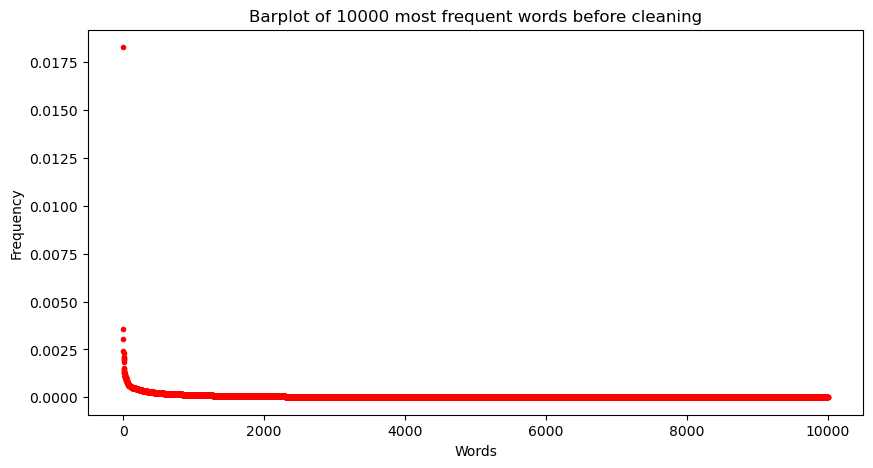

In [66]:
# Analysis of word frequency
freq_100_post = sorted(word_dict_post.items(), key=lambda x: x[1], reverse=True)[0:100]
freq_10000_post = sorted(word_dict_post.items(), key=lambda x: x[1], reverse=True)[0:10000]
freq_10000_words_post = [word[0] for word in freq_10000_post]
word_sum_post = sum(word_dict_post.values())
frequency_10000_post = [word[1]/word_sum for word in freq_10000_post]

plt.figure(figsize=(10,5))
## Create bars
plt.plot(frequency_10000_post,'.',color='red')
plt.ylabel("Frequency")
plt.title("Barplot of 10000 most frequent words before cleaning")
plt.xlabel("Words")
plt.show()

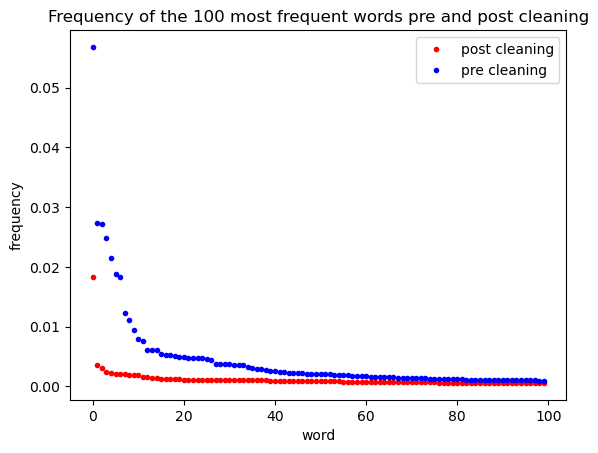

In [81]:
plt.plot(frequency_10000_post[0:100],'.',color='red',label='post cleaning')
plt.plot(frequency_10000[0:100],'.',color='blue',label='pre cleaning')
plt.title('Frequency of the 100 most frequent words pre and post cleaning')
plt.xlabel('word')
plt.ylabel('frequency')
plt.legend()
plt.show()

# Task 3

In [1]:
def tokenize_content(content, stop_words, stemmer):  
    cleaned_content = clean_text(content)
    tokens = nltk.word_tokenize(cleaned_content)
    # tokenize all alphabetic words
    tokens = [token for token in tokens if token.isalpha()]
    
    # remove stop words by filtering
    tokens_no_stop = [token for token in tokens if not token in stop_words]
    # stem words using Porterstemmer
    tokens_stem = [stemmer.stem(token) for token in tokens_no_stop]

    return tokens_stem

content_token = {'tokenized': []}
token_df = pd.DataFrame(content_token)
#big_df = pd.read_csv('995,000_rows.csv')
#big_df = big_df.dropna(subset = ['type'])
#big_df = big_df.dropna(subset = ['content'])

chunksize = 50000
counter = 0
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
for chunk in pd.read_csv('995,000_rows.csv', chunksize=chunksize):
    counter += 1
    print(counter)
    if counter == 6:
        token_df.to_csv('tokenized_content_1-5.csv', index=False)
        content_token = {'tokenized': []}
        token_df = pd.DataFrame(content_token)
    if counter == 11:
        token_df.to_csv('tokenized_content_6-10.csv', index=False)
        content_token = {'tokenized': []}
        token_df = pd.DataFrame(content_token)
    if counter == 16:
        token_df.to_csv('tokenized_content_11-15.csv', index=False)
        content_token = {'tokenized': []}
        token_df = pd.DataFrame(content_token)
    #if counter in [1,2,3,4,5]:
    #  continue
    #if counter in [5,6,7,8]:
    #  continue
    #if counter in [10,11,12,13,14]:
    #  continue
    #if counter in [15,16,17,18,19,20,21]:
    #  continue
    chunk = chunk.dropna(subset = ['type'])
    chunk = chunk.dropna(subset = ['content'])
    for i in range(len(chunk['content'])):
        content = chunk['content'].iloc[i]
        content_token = tokenize_content(content, stop_words, stemmer)
        token_df.loc[len(token_df.index)] = [content_token]
token_df.to_csv('tokenized_content_16-end.csv', index=False)



KeyboardInterrupt



# Task 4

In [103]:
from sklearn.model_selection import train_test_split
train_test_split(np.arange(len(df)), test_size=0.1,shuffle=True)

[array([150, 166, 188, 138,  97, 220,  47,  98, 244, 181,   4, 168, 179,
         66,  17,  57,  37, 232, 180, 208,  53,   0, 128, 118,  92, 216,
        120, 167, 237,  21,  25,  71, 243, 105, 127, 147,  70,  50, 124,
        183, 199, 136, 152,  42,  23,  29, 159, 102, 123,  46, 158, 119,
        191,  73,   8, 145,  39,   5, 165,   9, 240, 114,  61, 225,  65,
        213,  35,  43, 108,  19, 209,  14,  62, 126,  49, 178,  26, 153,
         45,  55, 154,   2,  40, 110, 241, 143, 211, 137,  38, 139, 217,
          3,  85,  54, 141, 155, 227,  74,  10,  31, 245, 224,  16, 111,
         59, 193, 236, 112, 246,  32,  69,  89, 129,  56, 230,  36, 122,
         51, 231,  63, 182, 242, 222, 248,   1, 100,  64, 214, 192, 201,
        172, 132, 212,  11,  48,  52, 106, 200, 204, 148, 107, 160,  79,
        104,  75, 247, 149,  81, 156, 133, 117, 190, 234,  77, 109, 144,
        103, 202,  94, 125,  12, 171, 164,  96, 215, 101,  33, 249,  15,
        116,  72, 235, 146,  99, 130,  22,  60, 189

# Part 2: Simple model

# Part 3: Advanced model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
big_df = pd.read_csv('995,000_rows.csv')
big_df = big_df.dropna(subset = ['type'])
big_df = big_df.dropna(subset = ['content'])

pp_df = pd.read_csv('rows_preprocessed.csv', index=False)
vectorizer = TfidfVectorizer()  
corpus = pp_df['tokenized'].iloc[0:100]
weights = vectorizer.fit_transform(corpus)
weights